In [1]:
# Importing libraries for Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

In [2]:
# Importing libraries for ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

In [4]:
from sklearn.utils import shuffle

In [5]:
train_dir = 'Brain_tumor_MRI/Training'
test_dir = 'Brain_tumor_MRI/Testing'

In [6]:
import os

# List directories in the root to understand the structure
print(os.listdir('/'))
# Verify these paths
print("Training Directory Exists:", os.path.exists(train_dir))
print("Testing Directory Exists:", os.path.exists(test_dir))


['$Recycle.Bin', '$WinREAgent', '7693ECE9ADD3', 'bootmgr', 'BOOTNXT', 'Darshan', 'Documents and Settings', 'DumpStack.log', 'DumpStack.log.tmp', 'hpswsetup', 'MSOCache', 'OneDriveTemp', 'pagefile.sys', 'PerfLogs', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Recovery', 'swapfile.sys', 'SWSetup', 'System Volume Information', 'system.sav', 'tenorshare', 'Users', 'Windows']
Training Directory Exists: True
Testing Directory Exists: True


In [7]:
train_paths = []
train_labels = []

In [8]:
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        train_paths.append(os.path.join(label_dir, image))
        train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

In [9]:
test_paths = []
test_labels = []

In [10]:
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        test_paths.append(image_path)
        test_labels.append(label)
test_paths, test_labels = shuffle(test_paths, test_labels)

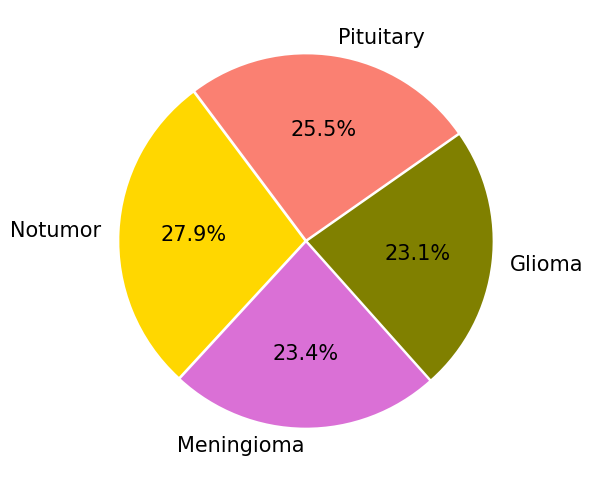

In [11]:
plt.figure(figsize=(14, 6))
color_palette = ['#FA8072', '#FFD700', '#DA70D6', '#808000']
plt.rcParams['font.size'] = 15
label_counts = [train_labels.count(label) for label in ['pituitary', 'notumor', 'meningioma', 'glioma']]
plt.pie(label_counts, labels=['Pituitary', 'Notumor', 'Meningioma', 'Glioma'],
        colors=color_palette, autopct='%1.1f%%', explode=[0.01] * 4, startangle=35)
plt.show()


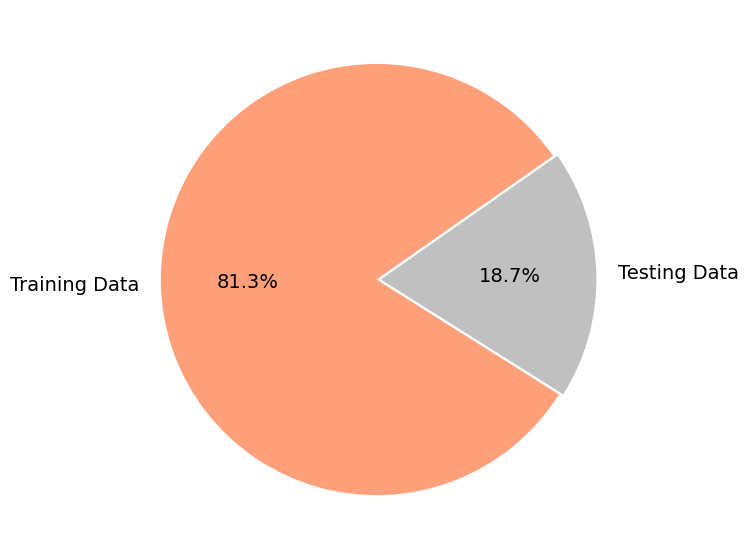

In [12]:
plt.figure(figsize=(12, 7))
custom_colors = ['#FFA07A', '#C0C0C0']
plt.rcParams['font.size'] = 14
data_sizes = [len(train_labels), len(test_labels)]
data_labels = ['Training Data', 'Testing Data']
plt.pie(data_sizes, labels=data_labels, colors=custom_colors, autopct='%1.1f%%',
        explode=(0.01, 0.01), startangle=35)
plt.show()


In [13]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.85, 1.15))  # Adjusting the sequence and range of contrast enhancements
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.85, 1.15))  # Adjusting the sequence and range of brightness enhancements
    image = np.array(image) / 255.0
    return image

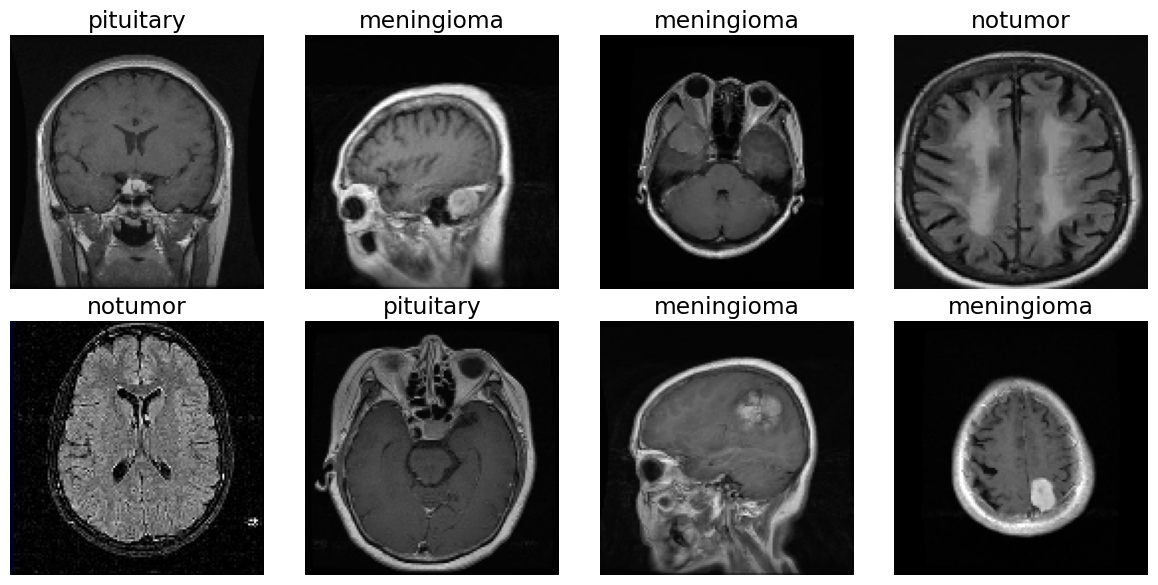

In [14]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]

# Setting up the figure for plotting
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, ax in enumerate(axes.flatten()):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis('off')
plt.tight_layout()
plt.show()


In [15]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [16]:
base_model = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False


trainable_layers = -4
for layer in base_model.layers[trainable_layers:]:
    layer.trainable = True

# Building the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))
model.summary()




87910968/87910968 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                       

In [17]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10


285/285 [==============================] - 44s 132ms/step - loss: 0.8271 - sparse_categorical_accuracy: 0.6768
Epoch 2/10
285/285 [==============================] - 36s 128ms/step - loss: 0.5325 - sparse_categorical_accuracy: 0.7941
Epoch 3/10
285/285 [==============================] - 36s 128ms/step - loss: 0.4496 - sparse_categorical_accuracy: 0.8305
Epoch 4/10
285/285 [==============================] - 37s 129ms/step - loss: 0.3899 - sparse_categorical_accuracy: 0.8572
Epoch 5/10
285/285 [==============================] - 36s 128ms/step - loss: 0.3471 - sparse_categorical_accuracy: 0.8654
Epoch 6/10
285/285 [==============================] - 36s 128ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.8832
Epoch 7/10
285/285 [==============================] - 37s 129ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8877
Epoch 8/10
285/285 [==============================] - 37s 131ms/step - loss: 0.2661 - sparse_categorical_accuracy: 0.9009
Epoch 9/10
285/285 [==

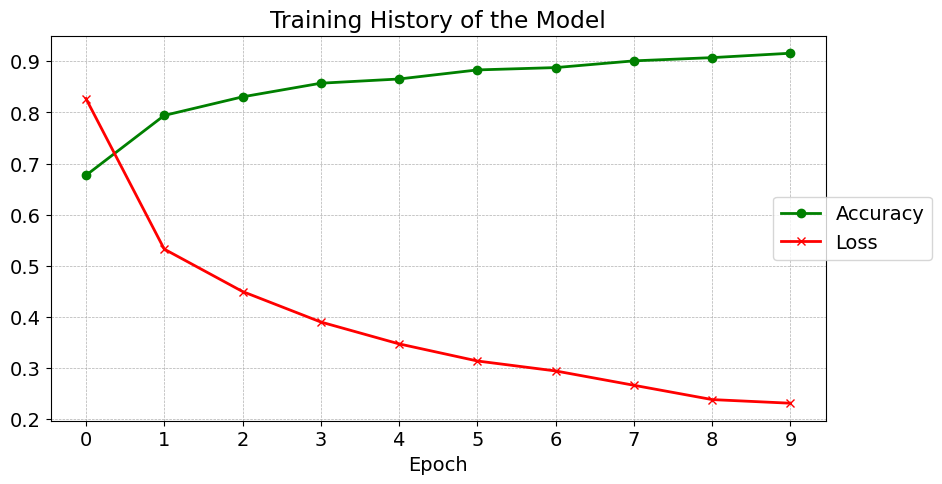

In [19]:
plt.figure(figsize=(10, 5))  # Adjusted figure size for better visibility
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting accuracy and loss with different marker styles
plt.plot(history.history['sparse_categorical_accuracy'], marker='o', color='green', linestyle='-', linewidth=2)
plt.plot(history.history['loss'], marker='x', color='red', linestyle='-', linewidth=2)

# Updated title and labels for clarity
plt.title('Training History of the Model')
plt.xlabel('Epoch')
plt.xticks(range(epochs))

plt.legend(['Accuracy', 'Loss'], loc='center right', bbox_to_anchor=(1.15, 0.5))
plt.show()


In [20]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▎         | 1/40 [00:01<01:04,  1.65s/it]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2/40 [00:01<00:33,  1.14it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3/40 [00:02<00:23,  1.60it/s]

1/1 [==============================] - 0s 157ms/step


 10%|█         | 4/40 [00:02<00:17,  2.03it/s]

1/1 [==============================] - 0s 155ms/step


 12%|█▎        | 5/40 [00:02<00:14,  2.40it/s]

1/1 [==============================] - 0s 157ms/step


 15%|█▌        | 6/40 [00:03<00:12,  2.69it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 7/40 [00:03<00:11,  2.94it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 8/40 [00:03<00:10,  3.09it/s]

1/1 [==============================] - 0s 177ms/step


 22%|██▎       | 9/40 [00:04<00:09,  3.19it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▌       | 10/40 [00:04<00:09,  3.29it/s]

1/1 [==============================] - 0s 161ms/step


 28%|██▊       | 11/40 [00:04<00:08,  3.41it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 12/40 [00:04<00:08,  3.48it/s]

1/1 [==============================] - 0s 168ms/step


 32%|███▎      | 13/40 [00:05<00:07,  3.38it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 14/40 [00:05<00:07,  3.43it/s]

1/1 [==============================] - 0s 154ms/step


 38%|███▊      | 15/40 [00:05<00:07,  3.44it/s]

1/1 [==============================] - 0s 167ms/step


 40%|████      | 16/40 [00:06<00:06,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 42%|████▎     | 17/40 [00:06<00:06,  3.50it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▌     | 18/40 [00:06<00:06,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 19/40 [00:06<00:05,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 50%|█████     | 20/40 [00:07<00:05,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 52%|█████▎    | 21/40 [00:07<00:05,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 22/40 [00:07<00:05,  3.50it/s]

1/1 [==============================] - 0s 179ms/step


 57%|█████▊    | 23/40 [00:08<00:04,  3.40it/s]

1/1 [==============================] - 0s 176ms/step


 60%|██████    | 24/40 [00:08<00:04,  3.42it/s]

1/1 [==============================] - 0s 164ms/step


 62%|██████▎   | 25/40 [00:08<00:04,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████▌   | 26/40 [00:08<00:04,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 68%|██████▊   | 27/40 [00:09<00:03,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 70%|███████   | 28/40 [00:09<00:03,  3.49it/s]

1/1 [==============================] - 0s 153ms/step


 72%|███████▎  | 29/40 [00:09<00:03,  3.46it/s]

1/1 [==============================] - 0s 169ms/step


 75%|███████▌  | 30/40 [00:10<00:02,  3.43it/s]

1/1 [==============================] - 0s 176ms/step


 78%|███████▊  | 31/40 [00:10<00:02,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 32/40 [00:10<00:02,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▎ | 33/40 [00:10<00:02,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████▌ | 34/40 [00:11<00:01,  3.49it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 35/40 [00:11<00:01,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 90%|█████████ | 36/40 [00:11<00:01,  3.55it/s]

1/1 [==============================] - 0s 176ms/step


 92%|█████████▎| 37/40 [00:12<00:00,  3.49it/s]

1/1 [==============================] - 0s 180ms/step


 95%|█████████▌| 38/40 [00:12<00:00,  3.43it/s]

1/1 [==============================] - 0s 164ms/step


 98%|█████████▊| 39/40 [00:12<00:00,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 40/40 [00:12<00:00,  3.56it/s]

1/1 [==============================] - 1s 1s/step


41it [00:14,  2.85it/s]                        


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.92      0.85      0.89       300
  meningioma       0.80      0.88      0.84       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.92      0.90      0.91       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



In [22]:
#!pip install scikit-plot

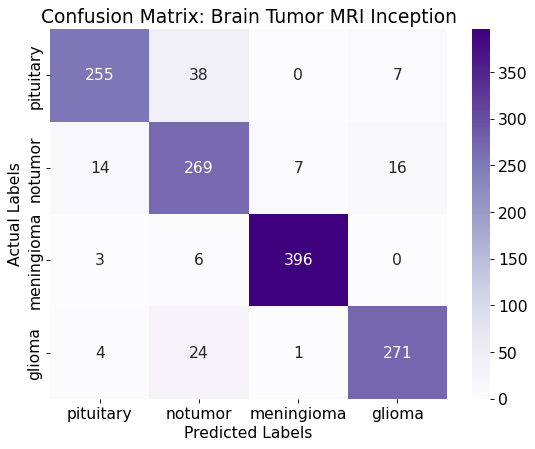

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

labels=['pituitary', 'notumor', 'meningioma', 'glioma']

# Generating the confusion matrix
cnf = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='white', edgecolor='gray')
ax = sns.heatmap(cnf, annot=True, cmap='Purples', fmt='d',
                 xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix: Brain Tumor MRI Inception')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Assuming 'model' and 'unique_labels' are defined somewhere in your code

# Define the path to your image
image_path = 'Brain_tumor_MRI/Testing/pituitary/Te-piTr_0005.jpg'

# Load and preprocess the image
my_image = load_img(image_path, target_size=(128, 128))
my_image = img_to_array(my_image)
my_image = my_image / 255.0  # Normalize pixel values
my_image = my_image.reshape((1, *my_image.shape))

# Assuming 'unique_labels' is defined somewhere in your code
print(unique_labels, '\n')

# Make the prediction
prediction = model.predict(my_image)
print(prediction, '\n')

# Find the predicted class
predict_index = prediction.argmax()
if predict_index == 1:
    print("There is no tumor")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # Display the image
    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a tumor")


['glioma', 'meningioma', 'notumor', 'pituitary'] 

1/1 [==============================] - 0s 125ms/step
[[6.5249827e-04 3.3797240e-03 3.6480388e-04 9.9560308e-01]] 

There is a tumor


The tumor is: MENINGIOMA


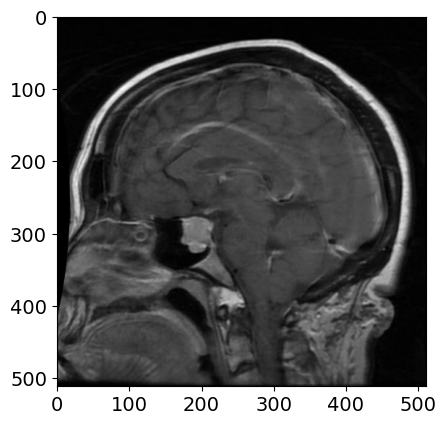

In [26]:
if(predict_index!=1):
    if(predict_index==2):
        print("The tumor is: PITUITARY")
    elif(predict_index==3):
        print("The tumor is: MENINGIOMA")
    else:
        if(predict_index==0):
            print("The tumor is: GLIOMA")

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()